# DAT 402 Project 2

# Plant Disease Detection from Leaf Images

---

### Team Members:
- Pete VanBenthuysen
- Emily Szolnoki
---

### Project Goal:
The goal of this project is to predict whether a plant — specifically bell pepper, potato, or tomato — is healthy or afflicted by a specific disease based on an image of its leaf.
Rather than simply detecting the presence of disease, the model is designed to identify the exact type of illness, enabling farmers to make informed decisions about whether a plant is salvageable, treatable, or needs to be removed.

This project leverages deep learning to create a rapid, low-cost diagnostic tool for agriculture.
Early and accurate detection of plant diseases in these critical crops is essential for preventing crop loss, maintaining food supply chains, and promoting sustainable farming practices.

Traditional methods of diagnosing plant diseases can be slow, require expert knowledge, and are often inaccessible to farmers in rural or resource-limited settings.
By training a convolutional neural network (CNN) on a large dataset of real-world agricultural images, we aim to automate disease identification across a wide range of conditions with high accuracy.

This project demonstrates how machine learning can transform agriculture by making expert-level diagnostics accessible to everyone — helping farmers make faster, more informed decisions, reduce unnecessary pesticide use, improve crop yields, and enhance global food security.
It also opens pathways for building mobile applications or embedded systems that bring AI-powered diagnostics directly into the hands of agricultural workers worldwide.

---

### Dataset:
We are using the "PlantVillage" dataset, sourced from Kaggle.  
The dataset contains over 20,000 labeled images of plant leaves, specifically focusing on three crops: bell peppers, potatoes, and tomatoes.
Each image is classified into one of 15 categories, representing either a specific disease or a healthy leaf.
The dataset is organized into folders based on the class label, with each folder containing images for a particular disease or healthy condition.
There are no missing values.
However, the distribution of images across classes is imbalanced, with certain diseases (such as Tomato Yellow Leaf Curl Virus) having significantly more samples than others (such as Potato healthy).

You can download the dataset [Here.](https://www.kaggle.com/datasets/emmarex/plantdisease)

After downloading, extract the contents into the `data/` folder of the project, preserving the folder structure.

In [1]:
import sys
import os
from pathlib import Path
import collections

# Define path to src
src_path = Path(os.getcwd()).resolve().parent / 'src'

# Add src/ to sys.path if needed
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Import config
import config

# Directory check
print(f"Using config from: {config.__file__}")
print(f"DATA_DIR path: {config.DATA_DIR}")

import tensorflow as tf


[CONFIG] DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\data
[CONFIG] MASKED_DATA_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\masked_data
[CONFIG] OUTPUTS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs
[CONFIG] RF_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_rf
[CONFIG] CNN_SPLITS_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn_transformed
[CONFIG] CNN_VAL_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
[CONFIG] CNN_TEST_DIR set to: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test
Using config from: C:\Users\petev\OneDrive\Desktop\LeafLens\src\config.py
DATA_DIR path: C:\Users\petev\OneDrive\Desktop\LeafLens\data


- collections reference, path reference, clean code pathing reference

In [2]:
# Basic libraries
import random
import json
import shutil
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Image processing
from PIL import Image
import cv2

# Data preprocessing and augmentation
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split

# Machine learning models and metrics
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

# Deep learning libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Project-specific functions
from functions import (
    plot_crop_distribution,
    apply_leaf_mask,
    mask_and_save_all_images,
    is_split_complete,
    save_cnn_split,
    show_random_images,
    plot_compressed_scatter,
    plot_cluster_scatter,
    plot_autoencoder_loss_curve,
    plot_bottleneck_vs_loss,
    plot_final_autoencoder_loss,
    build_autoencoder
)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Using device: cpu


Imports and Setup:
We start by importing all necessary libraries for data handling, visualization, machine learning, and deep learning.
We also check if a GPU is available to speed up training.

Setting Random Seeds:
To ensure reproducibility across multiple runs, random seeds are set for `torch`, `numpy`, and `random` early in the project.  
This controls random processes such as data splitting, model initialization, and sampling. This helps ensure consistent and comparable results across experiments. [1] 

[1] [PyTorch Reproducibility Guide](https://pytorch.org/docs/stable/notes/randomness.html)

In [3]:
# Define the path to the main PlantVillage folder
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", "data", "PlantVillage"))

# Define the path to the duplicate PlantVillage folder
duplicate_path = os.path.join(base_path, "PlantVillage")

# Check if the duplicate folder exists
if os.path.exists(duplicate_path):
    print(f"Duplicate folder found at: {duplicate_path}")
    # Remove the duplicate folder and its contents
    shutil.rmtree(duplicate_path)
    print(f"Duplicate folder removed: {duplicate_path}")
else:
    print(f"No duplicate folder found at: {duplicate_path}")

No duplicate folder found at: c:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\PlantVillage


This code was implemented to address the issue of duplicate data in the PlantVillage dataset. Specifically, there was a nested `PlantVillage` folder inside the main `PlantVillage` directory, which contained duplicate data. This duplication could lead to:

- Data Redundancy: The same images being processed multiple times, which could skew the results of the analysis or model training.
- Increased Storage Usage: Unnecessary duplication of files increases storage requirements.
- Performance Issues: Processing duplicate data could slow down the pipeline and introduce inefficiencies.

The code ensures that the nested duplicate folder is identified and removed, leaving only the main `PlantVillage` folder with its subfolders intact.


Number of categories (classes): 15
Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Skipped invalid image C:\Users\petev\OneDrive\Desktop\LeafLens\data\PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c under category 'Tomato__Tomato_YellowLeaf__Curl_Virus': cannot identify image file 'C:\\Users\\petev\\OneDrive\\Desktop\\LeafLens\\data\\PlantVillage\\Tomato__Tomato_YellowLeaf__Curl_Virus\\svn-r6Yb5c'

Total images loaded: 20638
Each image shape: (128, 128, 3) (Height x Width x Channels)
Labels shape: (20638,)

--- Skipped Images Summary ---
Category 'Pepper__bell___Bacterial_spot': 0 images skipped
Category 'Pepp

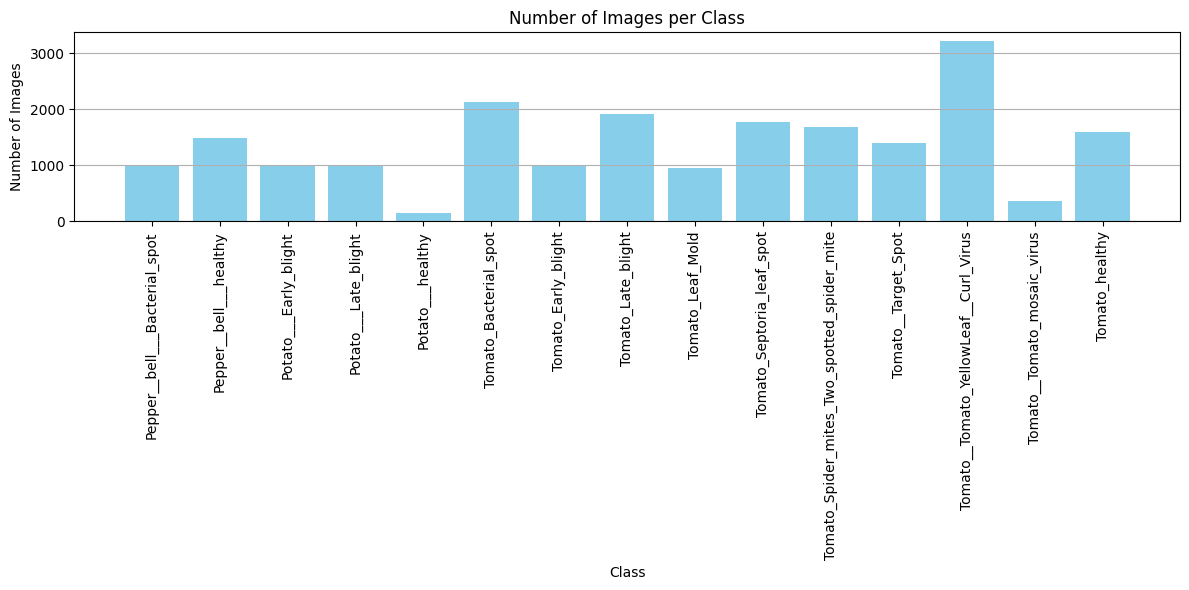


--- Observations ---
The dataset covers 15 different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.
Images are consistently resized to 128x128 pixels with 3 color channels (RGB).


In [4]:
# Path to the PlantVillage folder
plant_village_path = config.DATA_DIR / "PlantVillage"

# List categories (subfolders inside PlantVillage)
categories = sorted([folder.name for folder in plant_village_path.iterdir() if folder.is_dir()])
print(f"Number of categories (classes): {len(categories)}")
print("Classes:", categories)

# Load images and labels
images = []
labels = []
skipped_images = {}  # Dictionary to track skipped images per category

for label_idx, category in enumerate(categories):
    category_path = plant_village_path / category  # Path to the subfolder
    skipped_images[category] = 0  # Initialize skipped count for this category
    for img_name in os.listdir(category_path):  # Iterate over files in the subfolder
        img_path = category_path / img_name  # Full path to the image
        if img_path.is_file():  # Ensure it's a file (not a directory)
            try:
                img = Image.open(img_path).convert('RGB')  # Open the image
                img = img.resize((128, 128))  # Resize to a consistent shape
                img_array = np.array(img)  # Convert to a NumPy array
                images.append(img_array)  # Add the image to the list
                labels.append(label_idx)  # Add the corresponding label
            except (IOError, OSError) as e:
                print(f"Skipped invalid image {img_path} under category '{category}': {e}")
                skipped_images[category] += 1  # Increment skipped count for this category

images = np.array(images)
labels = np.array(labels)

# Print basic dataset characteristics
print(f"\nTotal images loaded: {images.shape[0]}")
print(f"Each image shape: {images.shape[1:]} (Height x Width x Channels)")
print(f"Labels shape: {labels.shape}")

# Print skipped images summary
print("\n--- Skipped Images Summary ---")
for category, count in skipped_images.items():
    print(f"Category '{category}': {count} images skipped")

# Plot a bar chart of class distribution
labels_df = pd.DataFrame({'label': labels})
class_counts = labels_df['label'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(range(len(categories)), class_counts.values, tick_label=categories, color='skyblue')
plt.xticks(rotation=90)
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Print observations
print("\n--- Observations ---")
print(f"The dataset covers {len(categories)} different plant disease and healthy categories, primarily across bell peppers, potatoes, and tomatoes.")
print("Images are consistently resized to 128x128 pixels with 3 color channels (RGB).")

## Dataset Description

The PlantVillage dataset is organized into 15 distinct classes, with each class represented as a subfolder under the `PlantVillage` directory.  
Each subfolder corresponds to a specific plant disease or a healthy plant condition across bell peppers, potatoes, and tomatoes.

### Data Loading and Cleaning Steps

- For each class, all files within its subfolder were iterated.
- Only valid image files (non-directories) were processed.
- Images were opened with the Pillow (PIL) library, converted to RGB, and resized to 128×128 pixels. [2]
- Invalid or unreadable files (e.g., corrupted or non-image files) were safely skipped without interrupting the loading process.
- Skipped images were tracked per category for auditing purposes.

### Dataset Characteristics

- Total of 20,638 valid images successfully loaded.
- Each image is a NumPy array of shape (128, 128, 3).
- Labels were assigned as integer IDs (0–14) based on the alphabetical order of class names.

### Observations

- The dataset exhibits a class imbalance, with diseases like *Tomato Yellow Leaf Curl Virus* overrepresented compared to others like *Potato Healthy*. 
- Addressing class imbalance during model training (e.g., through data augmentation or class-weighted loss) is important to prevent bias.
- The dataset is rich, diverse, and well-structured, providing a strong foundation for developing machine learning models, particularly Convolutional Neural Networks (CNNs) for image classification tasks.

[2] [Pillow documentation](https://realpython.com/image-processing-with-the-python-pillow-library/)


--- Potato Dataset ---
Healthy: 152 images
Infected (Potato___Early_blight): 1000 images
Infected (Potato___Late_blight): 1000 images


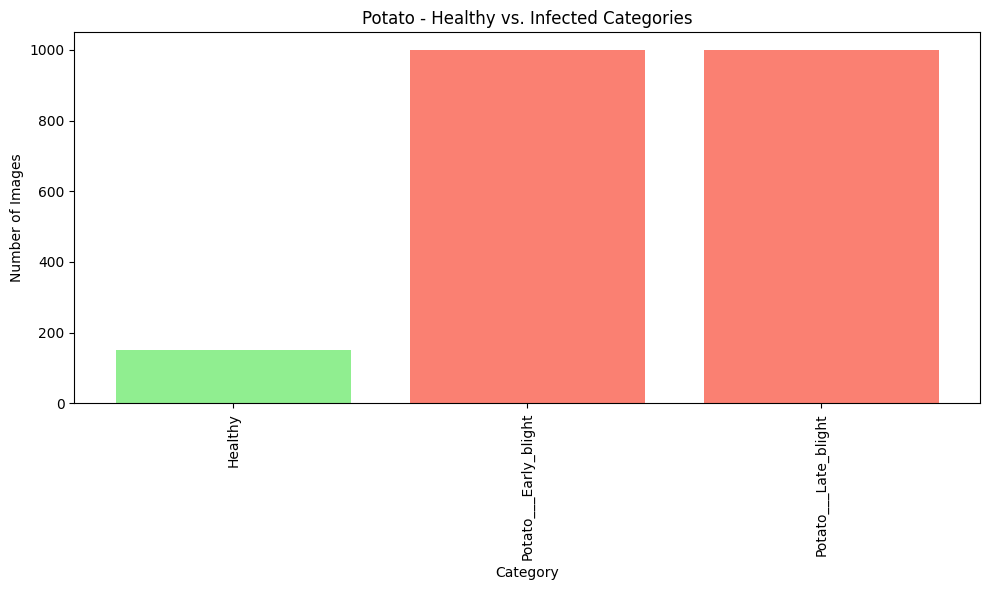


--- Pepper Dataset ---
Healthy: 1478 images
Infected (Pepper__bell___Bacterial_spot): 997 images


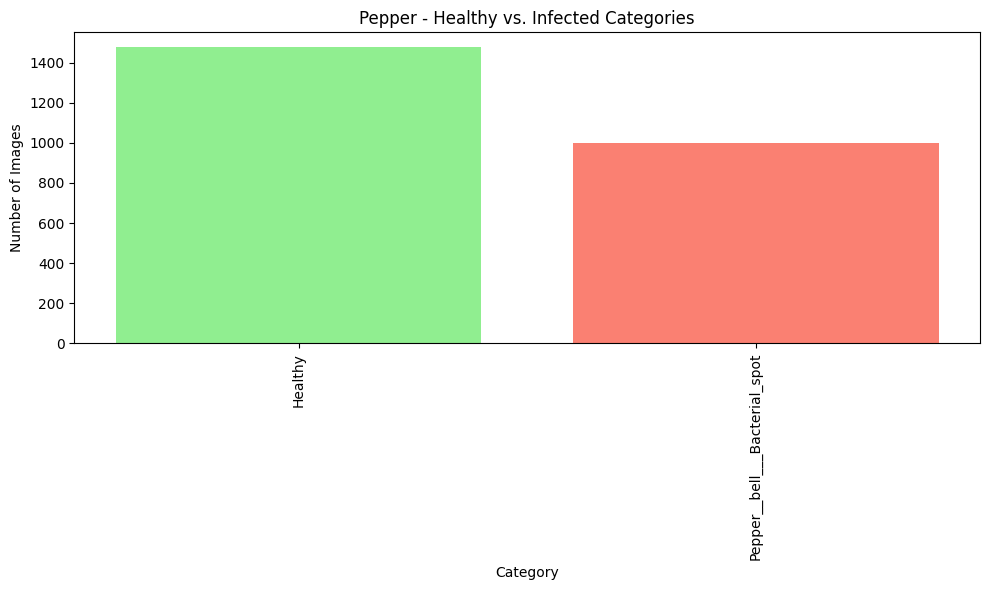


--- Tomato Dataset ---
Healthy: 1591 images
Infected (Tomato_Bacterial_spot): 2127 images
Infected (Tomato_Early_blight): 1000 images
Infected (Tomato_Late_blight): 1909 images
Infected (Tomato_Leaf_Mold): 952 images
Infected (Tomato_Septoria_leaf_spot): 1771 images
Infected (Tomato_Spider_mites_Two_spotted_spider_mite): 1676 images
Infected (Tomato__Target_Spot): 1404 images
Infected (Tomato__Tomato_YellowLeaf__Curl_Virus): 3208 images
Infected (Tomato__Tomato_mosaic_virus): 373 images


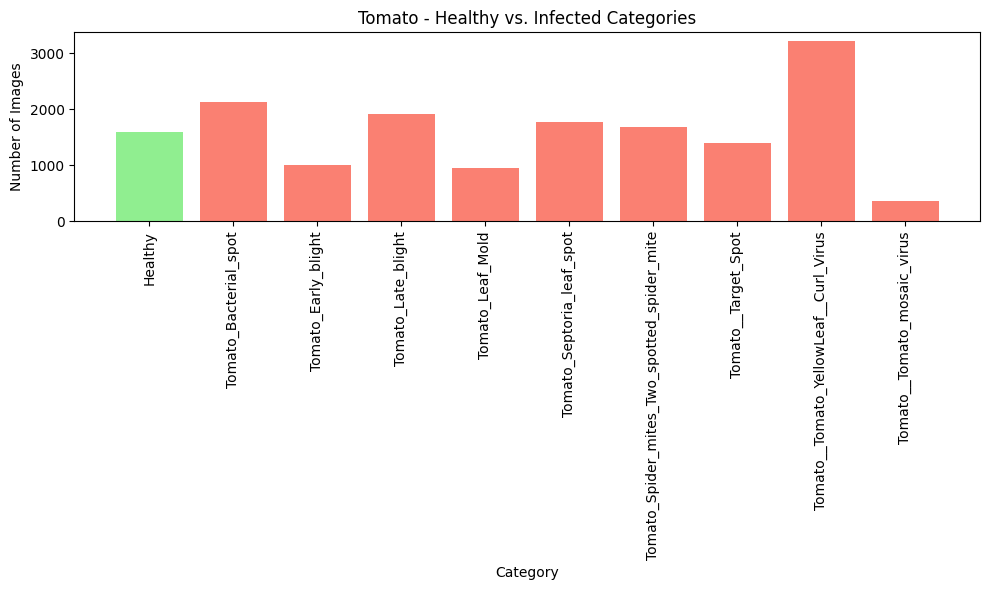

In [5]:
# Bar chart of class distribution
# Group categories into healthy and infected for each crop
crops = {
    "Potato": {"healthy": 0, "infected": {}},
    "Pepper": {"healthy": 0, "infected": {}},
    "Tomato": {"healthy": 0, "infected": {}}
}

# Map numeric indices in class_counts to category names
for label_idx, count in class_counts.items():
    category = categories[label_idx]  # Get the category name from the index
    if "Potato" in category:
        if "healthy" in category.lower():
            crops["Potato"]["healthy"] += count
        else:
            crops["Potato"]["infected"][category] = count
    elif "Pepper" in category:
        if "healthy" in category.lower():
            crops["Pepper"]["healthy"] += count
        else:
            crops["Pepper"]["infected"][category] = count
    elif "Tomato" in category:
        if "healthy" in category.lower():
            crops["Tomato"]["healthy"] += count
        else:
            crops["Tomato"]["infected"][category] = count


# Plot bar charts for each crop
for crop_name, crop_data in crops.items():
    print(f"\n--- {crop_name} Dataset ---")
    print(f"Healthy: {crop_data['healthy']} images")
    for category, count in crop_data["infected"].items():
        print(f"Infected ({category}): {count} images")
    plot_crop_distribution(crop_name, crop_data)

Across the datasets, a notable class imbalance between healthy and infected samples exists.
Potato shows a severe shortage of healthy samples (152 vs 2000 infected), while Pepper is more balanced.
Tomato is strongly dominated by infected samples, with several disease classes individually surpassing the number of healthy images.
Such imbalances must be considered carefully during model development to avoid biased learning outcomes.

In [6]:
"""
# Mask all images
mask_and_save_all_images()

# Path to masked dataset
masked_plant_village_path = config.MASKED_DATA_DIR / "PlantVillage"

images = []
labels = []

# Iterate through masked images
for label_idx, category in enumerate(sorted([folder.name for folder in masked_plant_village_path.iterdir() if folder.is_dir()])):
    category_path = masked_plant_village_path / category
    for img_name in os.listdir(category_path):
        img_path = category_path / img_name
        if img_path.is_file():
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))
            img_array = np.array(img)
            images.append(img_array)
            labels.append(label_idx)

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} masked images.")
print(f"Unique classes found: {len(np.unique(labels))}")

config.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)
np.save(config.MASKED_ARRAYS_DIR / 'images.npy', images)
np.save(config.MASKED_ARRAYS_DIR / 'labels.npy', labels)
"""

'\n# Mask all images\nmask_and_save_all_images()\n\n# Path to masked dataset\nmasked_plant_village_path = config.MASKED_DATA_DIR / "PlantVillage"\n\nimages = []\nlabels = []\n\n# Iterate through masked images\nfor label_idx, category in enumerate(sorted([folder.name for folder in masked_plant_village_path.iterdir() if folder.is_dir()])):\n    category_path = masked_plant_village_path / category\n    for img_name in os.listdir(category_path):\n        img_path = category_path / img_name\n        if img_path.is_file():\n            img = Image.open(img_path).convert(\'RGB\')\n            img = img.resize((128, 128))\n            img_array = np.array(img)\n            images.append(img_array)\n            labels.append(label_idx)\n\n# Convert lists to arrays\nimages = np.array(images)\nlabels = np.array(labels)\n\nprint(f"Loaded {len(images)} masked images.")\nprint(f"Unique classes found: {len(np.unique(labels))}")\n\nconfig.MASKED_ARRAYS_DIR.mkdir(parents=True, exist_ok=True)\nnp.save(c

Talk about why we are NOT masking data, reduced model performance by 10%


In [ ]:
# Check the number of images and labels
print(f"Number of images: {images.shape[0]}")
print(f"Number of labels: {len(labels)}")

# Ensure the number of labels matches the number of images
assert len(labels) == images.shape[0], "Mismatch between the number of images and labels"

# Flatten and normalize pixel values
X_flat = images.reshape(images.shape[0], -1) / 255.0
print(f"Shape after flattening: {X_flat.shape}")

# Split for training the Autoencoder
train_images, val_images = train_test_split(X_flat, test_size=0.2, random_state=42)

input_dim = train_images.shape[1]

# List of bottleneck sizes to test
bottleneck_candidates = [100, 200,] #Training on CPU takes too long for larger sizes
bottleneck_results = {}

# Train Autoencoders with different bottlenecks
for bottleneck_dim in bottleneck_candidates:
    print(f"Training Autoencoder with bottleneck_dim = {bottleneck_dim}")

    autoencoder = build_autoencoder(input_dim, bottleneck_dim)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    history = autoencoder.fit(
        train_images, train_images,
        epochs=50,
        batch_size=256,
        validation_data=(val_images, val_images),
        callbacks=[early_stopping],
        verbose=1
    )

    # Get final validation loss
    final_val_loss = history.history['val_loss'][-1]
    bottleneck_results[bottleneck_dim] = final_val_loss

# Plot bottleneck size vs final validation loss

plot_bottleneck_vs_loss(
    bottleneck_results,
    save_path=config.EDA_DIR / 'bottleneck_vs_loss.png'
)

# Choose best bottleneck

best_bottleneck_dim = min(bottleneck_results, key=bottleneck_results.get)
print(f"Best bottleneck dimension selected: {best_bottleneck_dim}")

# Save bottleneck optimization results to JSON

optimization_results = {
    "all_bottlenecks": bottleneck_results,
    "best_bottleneck_dim": best_bottleneck_dim,
    "best_val_loss": bottleneck_results[best_bottleneck_dim]
}

with open(config.EDA_DIR / 'bottleneck_optimization_results.json', 'w') as f:
    json.dump(optimization_results, f, indent=4)

print(f"Saved optimization results JSON to {config.EDA_DIR / 'bottleneck_optimization_results.json'}")

# Retrain final autoencoder with best bottleneck

autoencoder = build_autoencoder(input_dim, best_bottleneck_dim)

history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=256,
    validation_data=(val_images, val_images),
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)],
    verbose=1
)

# Save final optimized loss curve

plot_final_autoencoder_loss(
    history,
    best_bottleneck_dim,
    save_path=config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'
)

print(f"Saved final optimized loss curve to {config.EDA_DIR / 'optimized_autoencoder_loss_curve.png'}")

# Compress all images using final trained model

bottleneck_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
compressed_features = bottleneck_model.predict(X_flat, batch_size=256)

print(f"Compressed features shape: {compressed_features.shape}")

# Apply t-SNE for 2D visualization

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(compressed_features)

print(f"Shape after t-SNE reduction: {features_2d.shape}")

# Encode true labels numerically
unique_labels = np.unique(labels)
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
numeric_labels = np.array([label_to_int[label] for label in labels])

# Plot compressed feature space colored by true labels
plot_compressed_scatter(
    features_2d,
    numeric_labels,
    title='True Labels on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'true_labels_autoencoder_scatter.png'
)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=15, random_state=42)
clusters = kmeans.fit_predict(compressed_features)
print(f"Cluster assignments shape: {clusters.shape}")

# Plot compressed feature space colored by KMeans clusters
plot_compressed_scatter(
    features_2d,
    clusters,
    title='KMeans Clustering on Autoencoder Compressed Features',
    save_path=config.EDA_DIR / 'kmeans_autoencoder_scatter.png'
)


Number of images: 20638
Number of labels: 20638
Shape after flattening: (20638, 49152)
Training Autoencoder with bottleneck_dim = 100
Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 426ms/step - loss: 0.0291 - val_loss: 0.0241
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - loss: 0.0226 - val_loss: 0.0189
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - loss: 0.0193 - val_loss: 0.0182
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.0183 - val_loss: 0.0175
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - loss: 0.0166 - val_loss: 0.0164
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.0164 - val_loss: 0.0157
Epoch 8/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 387ms/step - loss: 0.0157 - val_loss: 0.0151
Epoch 9/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 25s 389ms/step - loss: 0.0154 - val_loss: 0.0150
Epoch 10/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - loss: 0.0153 - va

mention we are going with a hard cap of 300, not the n value because it is computationally too expensive to run but were showing graphs with that 90% variance n value (depends what the n value is)


### PCA Visualization Analysis

After flattening the leaf images and applying Principal Component Analysis (PCA) to reduce the dimensionality, we visualized the resulting principal components in a 2D scatter plot.  
Each point in the plot represents an individual leaf image, positioned based on its major sources of pixel variance captured by PCA.

#### Dataset and Processing Overview:
- Number of images: 20,638
- Number of labels: 20,638
- Flattened feature size: 49,152 features per image (128×128×3)
- PCA reduced shape: (20,638, 2) (two principal components per image)
- Cluster assignments shape (after K-Means): (20,638,)

The scatter plot reveals that while some classes form partially distinct clusters, there is significant overlap among most categories.  
This overlap indicates that raw pixel intensity patterns alone are not sufficient for clean separation of plant diseases, highlighting the limitations of pixel-level features.  
Such findings reinforce the importance of applying deeper feature extraction techniques, such as convolutional layers in CNNs, to learn more abstract and discriminative representations from images.

Interestingly, one distinct group of images appears isolated from the main distribution, suggesting that certain diseases—likely those with very unique visual symptoms—are more easily distinguishable even in low-dimensional pixel space.  
Overall, the PCA visualization provides valuable initial insights into the structure and complexity of the dataset, setting the stage for further analysis through clustering and supervised deep learning models.


In [8]:
# Normalize images
images_normalized = images / 255.0  # Normalize pixel values to [0, 1]

# Combine images and labels into a single dataset for stratified splitting
data = list(zip(images_normalized, labels))

# Split the dataset into train, validation, and test sets with stratification
train_data, temp_data = train_test_split(
    data, test_size=0.2, random_state=42, stratify=labels
)
val_data, test_data = train_test_split(
    temp_data, test_size=0.5, random_state=42, stratify=[label for _, label in temp_data]
)

# Debugging: Check split sizes
print(f"Train size: {len(train_data)}, Temp size: {len(temp_data)}")
print(f"Validation size: {len(val_data)}, Test size: {len(test_data)}")

# Unzip the data back into images and labels
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert back to NumPy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

# Debugging: Check label distributions
print(f"Train labels distribution: {collections.Counter(y_train)}")
print(f"Validation labels distribution: {collections.Counter(y_val)}")
print(f"Test labels distribution: {collections.Counter(y_test)}")

# Save CNN splits
cnn_split_dir = Path(config.OUTPUTS_DIR) / "splits_cnn"


if not cnn_split_dir.exists() or not all(
    is_split_complete(cnn_split_dir / split_name) for split_name in ["train", "val", "test"]
):  # Check if all splits are complete
    print("CNN splits are incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_split_dir, ignore_errors=True)  # Clear the directory if it exists
    cnn_split_dir.mkdir(parents=True, exist_ok=True)

    print(f"Saving training data to: {cnn_split_dir / 'train'}")
    save_cnn_split(cnn_split_dir, X_train, y_train, "train")

    print(f"Saving validation data to: {cnn_split_dir / 'val'}")
    save_cnn_split(cnn_split_dir, X_val, y_val, "val")

    print(f"Saving test data to: {cnn_split_dir / 'test'}")
    save_cnn_split(cnn_split_dir, X_test, y_test, "test")

    print("CNN splits saved in outputs folder.")
else:
    print("CNN splits already exist and are complete. Skipping save.")

# Save RF Splits
rf_split_dir = Path(config.OUTPUTS_DIR) / "splits_rf"
if not rf_split_dir.exists() or not any(rf_split_dir.iterdir()):  # Check if directory exists or is empty
    rf_split_dir.mkdir(parents=True, exist_ok=True)

    # Use compressed features instead of flattening images
    compressed_features_train, compressed_features_temp, y_train, y_temp = train_test_split(
        compressed_features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    compressed_features_val, compressed_features_test, y_val, y_test = train_test_split(
        compressed_features_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # Scale the compressed features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(compressed_features_train)  # Fit scaler on training compressed features
    X_val_scaled = scaler.transform(compressed_features_val)          # Transform validation compressed features
    X_test_scaled = scaler.transform(compressed_features_test)        # Transform test compressed features

    # Save RF splits
    np.save(rf_split_dir / "X_train.npy", X_train_scaled)
    np.save(rf_split_dir / "X_val.npy", X_val_scaled)
    np.save(rf_split_dir / "X_test.npy", X_test_scaled)
    np.save(rf_split_dir / "y_train.npy", y_train)
    np.save(rf_split_dir / "y_val.npy", y_val)
    np.save(rf_split_dir / "y_test.npy", y_test)

    print("RF splits saved in outputs folder (compressed features scaled).")
else:
    print("RF splits already exist and are not empty. Skipping save.")

Train size: 16510, Temp size: 4128
Validation size: 2064, Test size: 2064
Train labels distribution: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Validation labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Test labels distribution: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.

# Dataset Preparation for CNN and RF Models

This code prepares the dataset for both a Convolutional Neural Network (CNN) and a Random Forest (RF) model by performing data preprocessing, organizing splits, and saving the data in the appropriate formats. By moving the data into the outputs folder, we preserve the processed data used during our EDA and ensure consistent inputs for modeling.

## 1. Normalizing Image Data
The images are normalized by dividing the pixel values by 255.  
This scales pixel values to the range \([0, 1]\), which improves model training efficiency and convergence, especially for neural networks like CNNs.

## 2. Splitting the Dataset
The dataset is split into training, validation, and test sets:

- First, 80% of the data is assigned to the training set.
- The remaining 20% is evenly split into validation and test sets (10% each).

To maintain consistent class distributions across all splits, stratified sampling is applied:

- For Random Forest (RF) data, stratification is based on the labels.
- For CNN data, the same stratified splits are used to ensure each class is proportionally represented across train, validation, and test sets.

This helps prevent class imbalance during training and evaluation. [3]

## 3. Preparing and Saving CNN Data
Before saving the data for the CNN model, the script checks if the CNN splits already exist in the output directory to avoid overwriting.  
If not, it:

- Saves normalized images as `.png` files.
- Organizes images into train, validation, and test folders.
- Further separates each folder into subfolders by class label (e.g., `class_0`, `class_1`, etc.).

Images are rescaled back to \([0, 255]\) when saving to maintain proper image formats.

**Note:**  
PCA is not applied to CNN data.  
The CNN model works directly with the normalized pixel values and full image structure.

## 4. Preparing and Saving RF Data with PCA
For the Random Forest model:

- The images are first flattened from 3D arrays \((128, 128, 3)\) into 1D vectors.
- The datasets are then scaled so all features contribute equally.
- PCA is then applied to reduce the dimensionality of these flattened vectors.

PCA is fit only on the training data to avoid data leakage:

- The PCA model is trained (fit) using only `X_train`.
- The same fitted PCA is then used to transform `X_val` and `X_test`.

After PCA transformation:

- The reduced-dimension arrays (`X_train_pca`, `X_val_pca`, `X_test_pca`) are saved as `.npy` files.
- Corresponding labels (`y_train`, `y_val`, `y_test`) are also saved.

## 5. Overview
This code carefully splits and saves the dataset, preparing two clean and separate pipelines:

- The CNN model will train directly on normalized images organized by class folders.
- The Random Forest model will train on PCA-reduced feature vectors, preventing data leakage and improving interpretability.

All steps ensure consistency, class balance, and proper separation between training, validation, and testing phases.


[3] [Stratifying both features and labels](https://carpentries-incubator.github.io/intro-image-classification-cnn/instructor/aio.html?utm_source=chatgpt.com)

In [9]:
# Define transformations for training data
transform = transforms.Compose([
    transforms.RandomRotation(degrees=30),  # Randomly rotate images by ±30 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, etc.
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally
    transforms.ToTensor()  # Convert image to tensor
])

# Function to check if a folder contains the expected data
def is_folder_complete(folder_path, labels):
    folder_path = Path(folder_path)
    if not folder_path.exists():
        return False  # Folder doesn't exist, so it's not complete

    # Check if all class folders exist and contain files
    for label in set(labels):  # Unique class labels
        class_dir = folder_path / f"class_{label}"
        if not class_dir.exists() or not any(class_dir.iterdir()):  # Check if folder exists and is not empty
            return False  # Missing or empty class folder

    return True  # Folder is complete

# Function to apply transformations and save augmented images
def apply_transformations_and_save(data, labels, output_dir):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    for idx, (img_array, label) in enumerate(zip(data, labels)):
        img = Image.fromarray((img_array * 255).astype(np.uint8))  # Convert back to PIL image
        transformed_img = transform(img)  # Apply transformations
        transformed_img = transforms.ToPILImage()(transformed_img)  # Convert back to PIL for saving
        
        # Save the transformed image
        class_dir = output_dir / f"class_{label}"
        class_dir.mkdir(parents=True, exist_ok=True)
        transformed_img.save(class_dir / f"img_{idx}_transformed.png")  # Add '_transformed' to the filename

# Transform and Save Training Data
cnn_train_dir_transformed = Path(config.OUTPUTS_DIR) / "splits_cnn_transformed" / "train"

if not is_folder_complete(cnn_train_dir_transformed, y_train):
    print("Transformed CNN training data is incomplete or missing. Regenerating...")
    shutil.rmtree(cnn_train_dir_transformed, ignore_errors=True)  # Clear only the transformed training directory
    apply_transformations_and_save(X_train, y_train, cnn_train_dir_transformed)  # Augment training set
    print("Transformed CNN training data saved.")
else:
    print("Transformed CNN training data already exists and is complete. Skipping transformation.")

# Debugging: Check validation and test directories
cnn_val_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "val"
cnn_test_dir = Path(config.OUTPUTS_DIR) / "splits_cnn" / "test"

if not cnn_val_dir.exists() or not any(cnn_val_dir.iterdir()):
    print(f"Validation directory is missing or empty: {cnn_val_dir}")
else:
    print(f"Validation directory exists and contains files: {cnn_val_dir}")

if not cnn_test_dir.exists() or not any(cnn_test_dir.iterdir()):
    print(f"Test directory is missing or empty: {cnn_test_dir}")
else:
    print(f"Test directory exists and contains files: {cnn_test_dir}")


Transformed CNN training data is incomplete or missing. Regenerating...
Transformed CNN training data saved.
Validation directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\val
Test directory exists and contains files: C:\Users\petev\OneDrive\Desktop\LeafLens\outputs\splits_cnn\test


This code applies data augmentation specifically to the CNN dataset splits by creating new, transformed versions of the training images. It is intended to improve model generalization by simulating real-world variability in the leaf images, such as changes in rotation, lighting, cropping, and orientation.

First, a transformation pipeline is defined using `transforms.Compose`. The pipeline randomly rotates images by ±30 degrees, applies random color jitter to adjust brightness, contrast, saturation, and hue, randomly resizes and crops images to 128x128 pixels, randomly flips images horizontally with a probability of 50%, and finally converts the augmented image to a tensor format. [4] [5]

The code then defines a function to check if a folder contains the expected data. If the folder is incomplete or missing, it is cleared and regenerated to ensure that the augmented images are up-to-date and complete.

A second function is defined to apply the transformations to each image and save the newly transformed versions into a new output directory. Each image is augmented individually, and the augmented images are saved under their respective class folders, with filenames labeled to indicate that they are transformed versions.

Next, the script checks whether the output folders for the transformed training dataset already exists. If it does not exist, the code clears or creates the appropriate folders and applies the transformations to the training dataset. If the folder already exists, it skips the transformation process to avoid redundant computation.

The training dataset for the CNN will now come from the splits_cnn_transformed directory, where the images have been augmented. However, the validation and test set images will continue to come from the original splits_cnn directory without any augmentation. This ensures that the model is evaluated on completely unaltered, real-world test images, maintaining a fair evaluation standard.

Meanwhile, the Random Forest (RF) dataset remains completely unchanged. No transformations or augmentations are applied to the RF data, as Random Forests are trained on flattened, non-image arrays where spatial information and visual transformations are not relevant.

In summary, this code ensures that the CNN model benefits from additional variability and robustness during training, while the RF model and the CNN test evaluation remain based on the original unaltered data. This careful separation of augmented and original data helps maintain training integrity while improving generalization.

[4] [Fine Tuning Transforms](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)
[5] [Transforming and Augmenting Images](https://rumn.medium.com/ultimate-guide-to-fine-tuning-in-pytorch-part-3-deep-dive-to-pytorch-data-transforms-53ed29d18dde)

Random Forest - Train Class Counts: Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})
Random Forest - Val Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 168, np.int64(14): 159, np.int64(1): 148, np.int64(11): 140, np.int64(3): 100, np.int64(2): 100, np.int64(6): 100, np.int64(0): 99, np.int64(8): 95, np.int64(13): 38, np.int64(4): 15})
Random Forest - Test Class Counts: Counter({np.int64(12): 321, np.int64(5): 213, np.int64(7): 191, np.int64(9): 177, np.int64(10): 167, np.int64(14): 159, np.int64(1): 148, np.int64(11): 141, np.int64(6): 100, np.int64(3): 100, np.int64(0): 100, np.int64(2): 100, np.int64(8): 95, np.int64(13): 37, np.int64(4): 15})

CNN - Train Class Counts: {'class_0': 

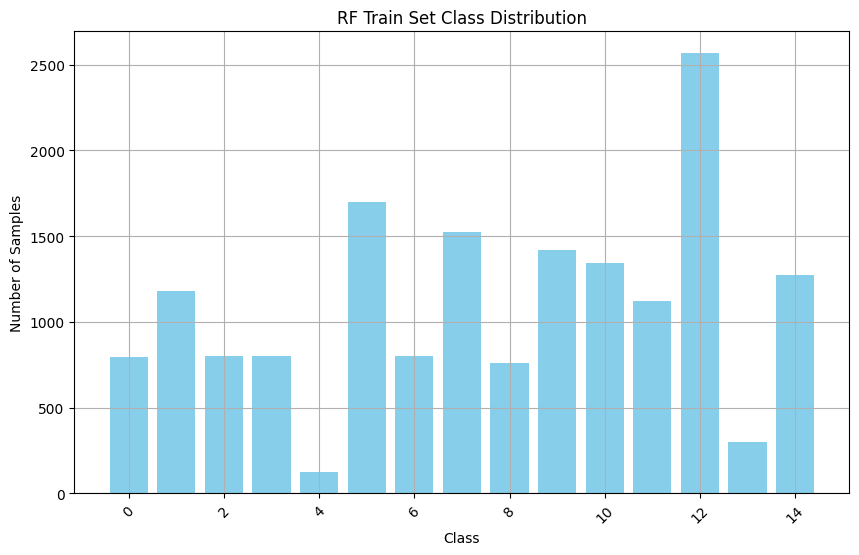

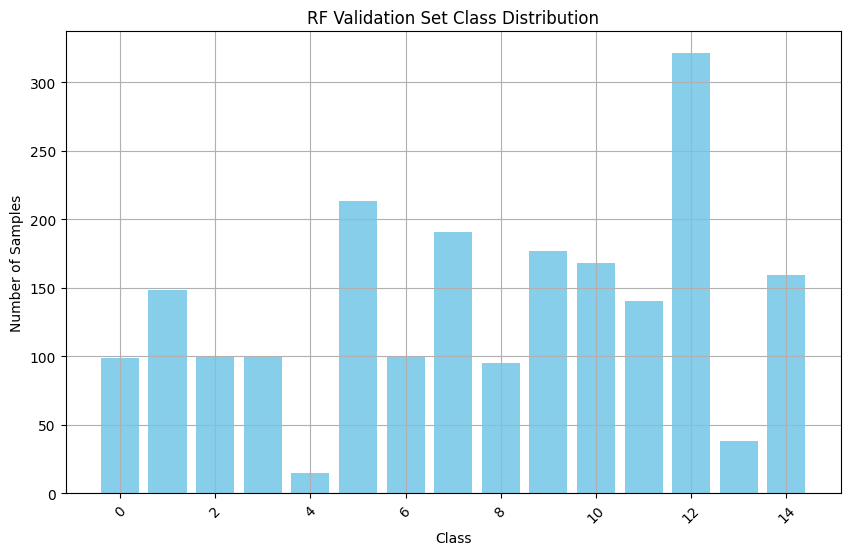

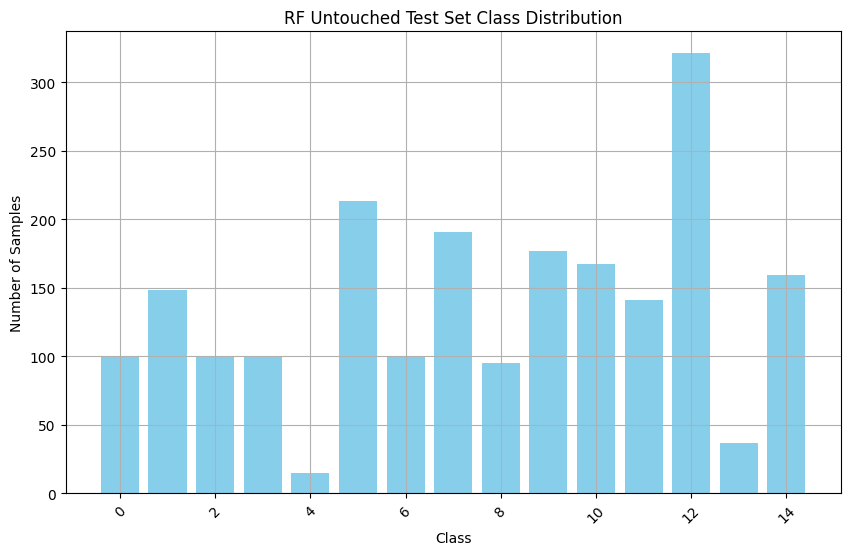

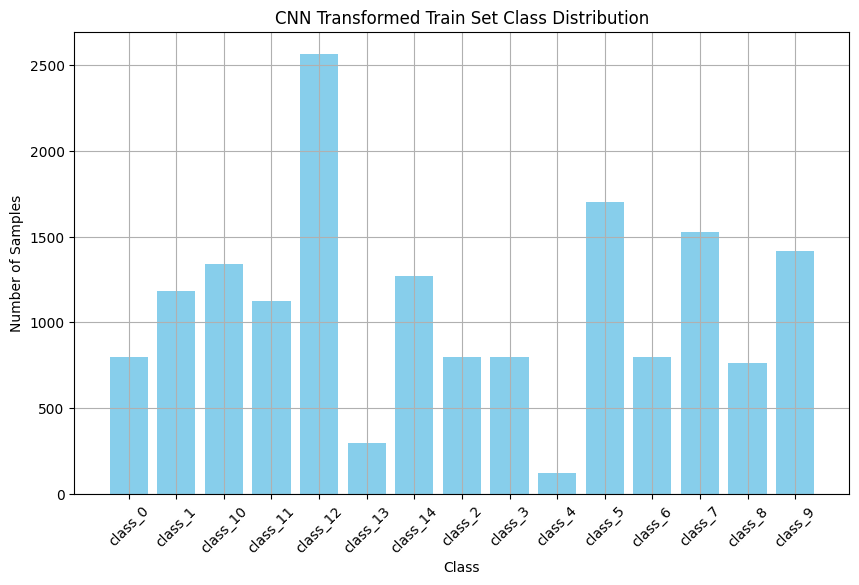

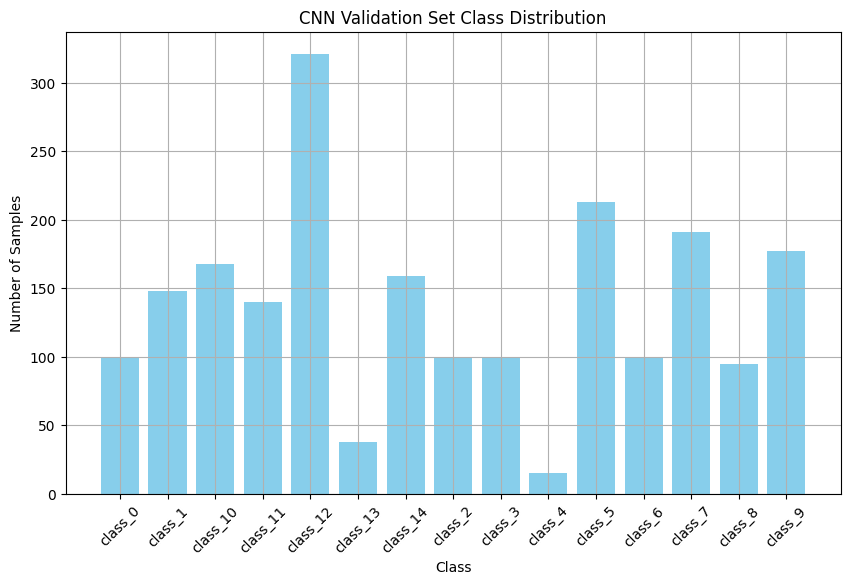

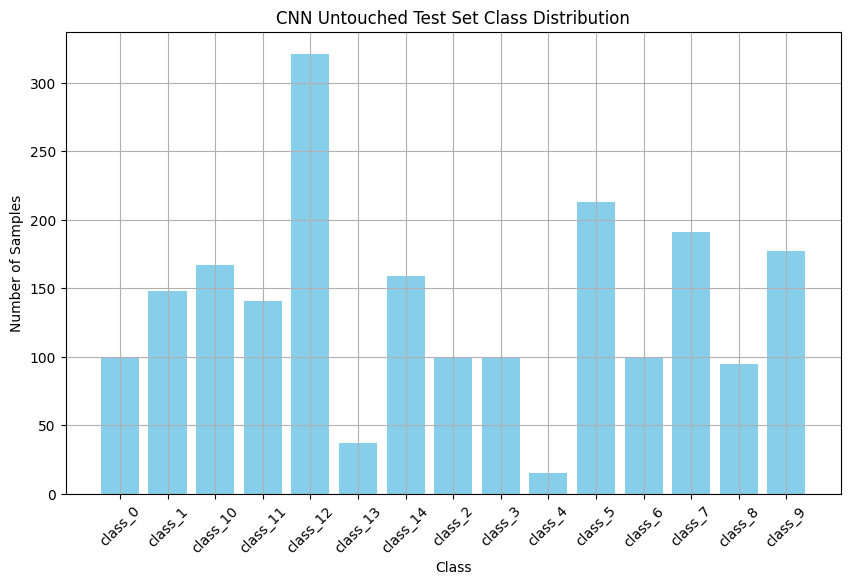

In [10]:
# Load labels
y_train = np.load(config.RF_SPLITS_DIR / 'y_train.npy')
y_val = np.load(config.RF_SPLITS_DIR / 'y_val.npy')
y_test = np.load(config.RF_SPLITS_DIR / 'y_test.npy')

# Count classes
print("Random Forest - Train Class Counts:", collections.Counter(y_train))
print("Random Forest - Val Class Counts:", collections.Counter(y_val))
print("Random Forest - Test Class Counts:", collections.Counter(y_test))


# CNN splits: Check image imbalance

def count_images_per_class(directory):
    directory = Path(directory)
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return {}  # Return an empty dictionary if the directory is missing

    counts = {}
    for class_folder in os.listdir(directory):
        class_path = os.path.join(directory, class_folder)
        if os.path.isdir(class_path):
            counts[class_folder] = len(os.listdir(class_path))
    return counts

# CNN Transformed splits (train)
cnn_train_counts = count_images_per_class(config.CNN_SPLITS_DIR / 'train')

# CNN Validation/Test split (untouched)
cnn_val_counts = count_images_per_class(config.CNN_VAL_DIR)
cnn_test_counts = count_images_per_class(config.CNN_TEST_DIR)

# Print counts
print("\nCNN - Train Class Counts:", cnn_train_counts)
print("CNN - Val Class Counts:", cnn_val_counts)
print("CNN - Test Class Counts:", cnn_test_counts)

# Plot class distribution for RF splits
def plot_rf_class_distribution(labels, title):
    
    class_counts = Counter(labels)  # Count occurrences of each class
    classes = list(class_counts.keys())
    nums = list(class_counts.values())
    
    plt.figure(figsize=(10, 6))
    plt.bar(classes, nums, color='skyblue')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Plotting RF class distributions
plot_rf_class_distribution(y_train, 'RF Train Set Class Distribution')
plot_rf_class_distribution(y_val, 'RF Validation Set Class Distribution')
plot_rf_class_distribution(y_test, 'RF Untouched Test Set Class Distribution')

# Plot class distribution for CNN splits

def plot_class_distribution(counts, title, x_labels=None):
   
    if x_labels is None:
        x_labels = list(counts.keys())
    nums = [counts.get(label, 0) for label in x_labels]  # Use 0 for missing labels
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, nums, color='skyblue')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Plotting
plot_class_distribution(cnn_train_counts, 'CNN Transformed Train Set Class Distribution')
plot_class_distribution(cnn_val_counts, 'CNN Validation Set Class Distribution')
plot_class_distribution(cnn_test_counts, 'CNN Untouched Test Set Class Distribution')


We first imported the paths to our Random Forest and CNN datasets using the config file to keep everything organized and flexible. We then loaded the Random Forest label arrays and CNN datasets and counted the number of samples for each class across the training, validation, and untouched test sets to confirm that stratification worked properly. We then plotted the class distributions to visually inspect whether any classes are severely underrepresented, helping us determine if additional data augmentation or balancing techniques might be needed before training our models.

In [11]:
# Paths
original_X_train_path = config.RF_SPLITS_DIR / 'X_train.npy'
original_y_train_path = config.RF_SPLITS_DIR / 'y_train.npy'
resampled_X_train_path = config.RF_SPLITS_DIR / 'X_train_resampled.npy'
resampled_y_train_path = config.RF_SPLITS_DIR / 'y_train_resampled.npy'
metadata_path = config.RF_SPLITS_DIR / 'resampling_metadata.json'

# Helper function to check if a file exists and is not empty
def is_valid_file(path):
    return path.exists() and path.stat().st_size > 0

# Check if resampling needs to be applied
if not (is_valid_file(resampled_X_train_path) and is_valid_file(resampled_y_train_path)):
    # Load the RF dataset splits
    X_train = np.load(original_X_train_path)
    y_train = np.load(original_y_train_path)

    # Print class distribution before SMOTETomek
    print("Class distribution before SMOTETomek:")
    print(Counter(y_train))

    # Apply SMOTETomek to balance the dataset
    smote_tomek = SMOTETomek(random_state=42)
    X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

    # Print class distribution after SMOTETomek
    print("\nClass distribution after SMOTETomek:")
    print(Counter(y_train_resampled))

    # Save the resampled data (no scaling, as it's already scaled)
    np.save(resampled_X_train_path, X_train_resampled)
    np.save(resampled_y_train_path, y_train_resampled)

    # Save metadata with more detailed info (e.g., shape of resampled data)
    metadata = {
        "original_class_distribution": dict(Counter(map(int, y_train))),
        "resampled_class_distribution": dict(Counter(map(int, y_train_resampled))),
        "resampling_method": "SMOTETomek",
        "random_state": 42,
        "original_data_shape": X_train.shape,
        "resampled_data_shape": X_train_resampled.shape  # Added this for better clarity
    }
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=4)

    print("\nResampled training data has been saved, along with metadata.")

else:
    print("Resampled data already exists and is valid. Skipping SMOTETomek.")

Class distribution before SMOTETomek:
Counter({np.int64(12): 2566, np.int64(5): 1701, np.int64(7): 1527, np.int64(9): 1417, np.int64(10): 1341, np.int64(14): 1273, np.int64(1): 1182, np.int64(11): 1123, np.int64(2): 800, np.int64(6): 800, np.int64(3): 800, np.int64(0): 798, np.int64(8): 762, np.int64(13): 298, np.int64(4): 122})

Class distribution after SMOTETomek:
Counter({np.int64(8): 2566, np.int64(4): 2566, np.int64(13): 2566, np.int64(14): 2565, np.int64(2): 2565, np.int64(3): 2565, np.int64(0): 2564, np.int64(6): 2564, np.int64(11): 2563, np.int64(1): 2561, np.int64(7): 2556, np.int64(10): 2555, np.int64(9): 2552, np.int64(5): 2548, np.int64(12): 2538})

Resampled training data has been saved, along with metadata.


In this code, we are preparing the training set for our Random Forest model by first checking if resampled data already exists. We define the file paths for the original training features and labels, as well as the intended paths for the resampled versions and metadata. To ensure reliability, we use a helper function called is_valid_file that checks whether a file not only exists but also is not empty, preventing errors caused by incomplete or corrupted files.

If the resampled training data does not already exist or is invalid, we proceed by loading the original PCA-transformed training features (`X_train_pca.npy`) and labels (`y_train.npy`). We print the class distribution before resampling so we can observe the existing imbalance across classes, which often hurts model performance.

To correct the class imbalance, we apply SMOTETomek, a hybrid resampling technique. SMOTETomek works in two stages: first, SMOTE (Synthetic Minority Oversampling Technique) generates synthetic samples for minority classes to make them better represented; second, Tomek Links identifies and removes overlapping or borderline samples between classes, cleaning noisy examples from the dataset. As a result, SMOTETomek not only increases the number of samples for underrepresented classes but also improves the quality of class boundaries by removing ambiguous samples. [6]

Importantly, because Tomek links remove samples even after SMOTE has added synthetic data, the final class counts are similar but not exactly equal across classes. Some classes that originally had borderline examples may end up with slightly fewer samples than others. This is expected behavior and is considered beneficial because it reduces noise and prevents the model from overfitting to bad examples. [7]

After resampling, we save the resampled, scaled features and corresponding labels separately to disk, ensuring they are preserved for later use. In addition, we generate and save a metadata.json file that records the original and resampled class distributions, the resampling method used, and the random state, providing clear documentation of how the training data was prepared.

If the resampled data already exists and is valid, the code simply skips reprocessing, printing a message to indicate this.

[6] [SmoteTOMEK](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html)
[7] [Rescaling After SMOTE](https://imbalanced-learn.org/stable/over_sampling.html#preprocessing)

In [12]:
# Set your directory
rf_split_dir = Path(config.OUTPUTS_DIR) / "splits_rf"

file_names = [
    "X_train.npy",
    "X_train_resampled.npy",
    "X_val.npy",
    "X_test.npy",
    "y_train.npy",
    "y_train_resampled.npy",
    "y_val.npy",
    "y_test.npy"
]

# Loop through each file and print the dtype
print("Confirmation of data types and shapes:\n")

for file_name in file_names:
    file_path = rf_split_dir / file_name
    data = np.load(file_path)
    print(f"{file_name}: dtype = {data.dtype}, shape = {data.shape}")

Confirmation of data types and shapes:

X_train.npy: dtype = float32, shape = (16510, 200)
X_train_resampled.npy: dtype = float32, shape = (38394, 200)
X_val.npy: dtype = float32, shape = (2064, 200)
X_test.npy: dtype = float32, shape = (2064, 200)
y_train.npy: dtype = int64, shape = (16510,)
y_train_resampled.npy: dtype = int64, shape = (38394,)
y_val.npy: dtype = int64, shape = (2064,)
y_test.npy: dtype = int64, shape = (2064,)
